# Quantum Machine Learning for Satellite Data Analysis with Qiskit

## Setting up the environment


In [1]:
import matplotlib.pyplot as plt
import json
import numpy as onp
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import minmax_scale

import pennylane as qml

from itertools import combinations
from scipy.linalg import logm

# Quantum Kernel Machine Learning

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space. This is the fundamental principle behind a series of machine learning algorithms known as *kernel methods*.

In this section, you will learn how to define quantum kernels using `Pennylane`.

## 1. Introduction

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering. **Spectral Clustering** is a technique where data points are treated as nodes of a graph, and the clustering task is viewed as a graph partitioning problem where nodes are mapped to a space where they can be easily segregated to form clusters.

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix:

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms.

## 2. Classification

This section illustrates a quantum kernel classification workflow using `Pennylane`.

### 2.1. Defining the dataset

For this example, we will use a cloud detection dataset, taking labeled pixels from the following image:

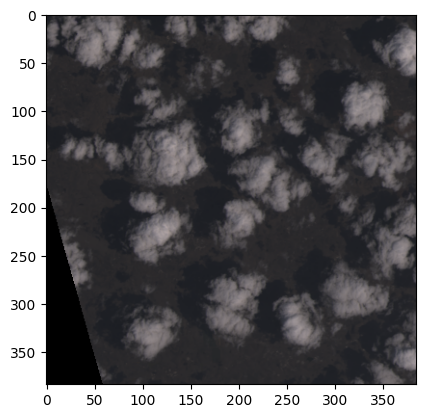

In [3]:
# Load and show image
clouds = plt.imread("../files/clouds.png")
plt.imshow(clouds)

We selected 100 labeled pixels for training and testing. They are in `clouds.json`.

In [4]:
with open('../files/clouds.json', 'r') as f:
    clouds_data = json.load(f)
x_full = onp.array(clouds_data['x'])
y = onp.array(clouds_data['y'])
print(x_full.shape, y.shape)

(100, 4) (100,)


**How do we visualize a 4-dimensional dataset?**

In [5]:
def prepare_PCA_dataset(x_full, n_components):
    pca = PCA(n_components=n_components)
    x = pca.fit_transform(x_full)
    x = minmax_scale(x, (0,onp.pi))
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
    return(x_train, x_test, y_train, y_test)

In [6]:
x_train, x_test, y_train, y_test = prepare_PCA_dataset(x_full, n_components=2)

We have measurements for four wavelengths: blue (450-515 nm), green (520-600 nm), red (630-680 nm) and NIR (845-885 nm) with labels '0' (no-clouds) and '1' (clouds).

We need to scale the features to $[0, 2\pi]$ so that we can encode them as rotation gates.
We also create the train-test splits.

Let's plot it now:

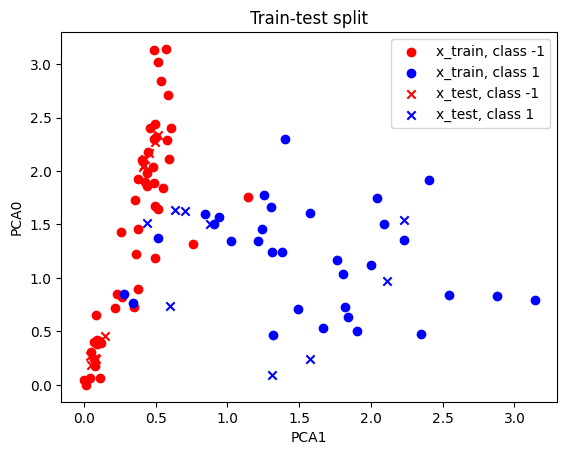

In [7]:
plt.scatter(*(x_train[y_train==-1].T), color='red', marker='o', label='x_train, class -1')
plt.scatter(*(x_train[y_train==1].T), color='blue', marker='o', label='x_train, class 1')
plt.scatter(*(x_test[y_test==-1].T), color='red', marker='x', label='x_test, class -1')
plt.scatter(*(x_test[y_test==1].T), color='blue', marker='x', label='x_test, class 1')
plt.legend()
plt.ylabel('PCA0')
plt.xlabel('PCA1')
plt.title('Train-test split')
plt.show()

In [8]:
def make_feature_map(dev, feature_map):
    """Create a qnode that prepares |phi(x)⟩."""
    @qml.qnode(dev)
    def circuit(x):
        feature_map(x)
        return qml.state()
    return circuit


def quantum_kernel(xs, ys, dev, feature_map):
    """
    Compute the quantum kernel matrix between two sets of inputs.

    Parameters
    ----------
    xs : array-like, shape (N, d)
        First set of data points.
    ys : array-like, shape (M, d)
        Second set of data points.
    dev : qml.Device
        Pennylane device.
    feature_map : callable
        Function implementing feature embedding using PennyLane gates.
        Must have signature feature_map(x).

    Returns
    -------
    K : onp.ndarray, shape (N, M)
        Quantum kernel matrix.
    """
    circuit = make_feature_map(dev, feature_map)

    N = len(xs)
    M = len(ys)
    K = onp.zeros((N, M))

    for i in range(N):
        psi_x = circuit(xs[i])
        for j in range(M):
            psi_y = circuit(ys[j])
            # Quantum fidelity kernel = |⟨psi(x)|psi(y)⟩|^2 # Explain scalar product!!
            K[i, j] = onp.abs(onp.dot(onp.conjugate(psi_x), psi_y)) ** 2

    return K

## Feature maps

In [9]:
n_wires = 3
dev_show_feature_maps = qml.device("default.qubit", wires=n_wires)

### Angle embedding

Very simple encoding, one encodes each feature of the data point as a rotation on the separate qubit.

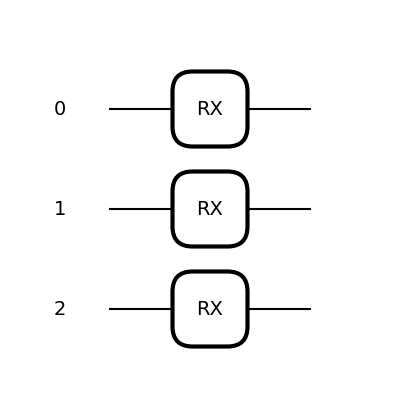

In [10]:
# Angle embedding feature map
def angle_embedding(x):
    for i in range(x.shape[0]):
        qml.RX(x[i], wires=[i])

qml.draw_mpl(angle_embedding)(onp.random.random(n_wires))
plt.show()

### ZZ-embedding

A **ZZ-feature** map encodes classical data into quantum states by applying single-qubit Z-rotations followed by pairwise ZZ entangling interactions whose phases depend on products of input features. This creates nonlinear, high-dimensional feature correlations that enhance the expressivity of quantum kernel methods.

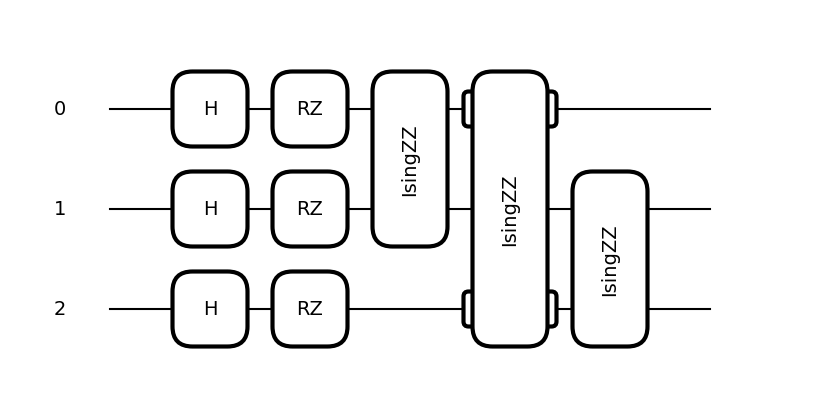

In [11]:
def ZZFeatureMap(x, reps=1):
    wires = range(x.shape[0])
    for _ in range(reps):

        # Single-Z rotations
        for i, w in enumerate(wires):
            qml.H(wires=w)
            qml.RZ(x[i], wires=w)

        # Entangling ZZ terms
        for (i, j) in combinations(wires, 2):
            qml.IsingZZ(x[i] * x[j], wires=[i, j])

qml.draw_mpl(ZZFeatureMap)(onp.random.random(n_wires))
plt.show()

### Classification

In [12]:
x_train, x_test, y_train, y_test = prepare_PCA_dataset(x_full, n_components=2)

### Classical baseline

In [13]:
clf_cl = SVC()
clf_cl.fit(x_train, y_train)
print("Training score: ", clf_cl.score(x_train, y_train))
print("Test score: ", clf_cl.score(x_test, y_test))

Training score:  0.9
Test score:  0.95


### Angle Embedding

In [14]:
# Device
dev = qml.device("default.qubit", wires=x_train.shape[1])

# Compute kernel matrix K(X, X)
K_train_angle = quantum_kernel(x_train, x_train, dev, angle_embedding)
K_test_angle = quantum_kernel(x_test, x_train, dev, angle_embedding)

In [15]:
clf = SVC(kernel='precomputed')
clf.fit(K_train_angle, y_train)
print("Training score: ", clf.score(K_train_angle, y_train))
print("Test score: ", clf.score(K_test_angle, y_test))

Training score:  0.9
Test score:  0.95


### ZZ-feature map embedding

In [16]:
# Device
dev = qml.device("default.qubit", wires=x_train.shape[1])

# Compute kernel matrix K(X, X)
K_train_ZZ = quantum_kernel(x_train, x_train, dev, ZZFeatureMap)
K_test_ZZ = quantum_kernel(x_test, x_train, dev, ZZFeatureMap)

In [17]:
clf = SVC(kernel='precomputed')
clf.fit(K_train_ZZ, y_train)
print("Training score: ", clf.score(K_train_ZZ, y_train))
print("Test score: ", clf.score(K_test_ZZ, y_test))

Training score:  0.9
Test score:  0.95


## Expressibility

Let's analyse the characteristics of the proposed feature map and the kernel matrix.

We will first start with **Expressibility** measure.

Generally speaking, expressibility connects with the size of the hypotheses set, from which machine learning
algorithms can learn. Feature maps with high expressibility can embed data on almost all available states, while
low expressibility feature maps explore only a small subset of available directions in the target space

We use the expressibility measure introduced in: 

[Z. Holmes, K. Sharma, M. Cerezo, and P. J. Coles, “Connecting ansatz expressibility to gradient magnitudes
and barren plateaus,” PRX Quantum, vol. 3, no. 1, p. 010313, 2022.],

where the authors compare the fidelity between the embedded states with the (Haar) random distribution of states.

The lower value of the measure, the closer we are to the "uniform" distribution of quantum states, and the bigger the expressibility of the feature map.
$$ \epsilon = \frac{1}{|U(x)|^2} \sum_{i,j} \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{4} - \frac{1}{2^{n-1}(2^n+1)} $$



In [18]:
def expressibility_from_kernel(K,n):
    N = K.shape[0]
    indep_K = K[onp.triu_indices(N, k=1)]
    epsilon = onp.mean(indep_K**2) - 1.0/((onp.power(2,n-1))*(onp.power(2.0, n)+1))
    return(epsilon)

In [19]:
#n=4
#x_train, x_test, y_train, y_test = prepare_PCA_dataset(x_full, n_components=n)
#dev = qml.device("default.qubit", wires=x_train.shape[1])

#K_train_angle = quantum_kernel(x_train, x_train, dev, angle_embedding)


#K_train_ZZ = quantum_kernel(x_train, x_train, dev, ZZFeatureMap)

expressibility_angle = expressibility_from_kernel(K_train_angle, n=x_train.shape[1])
print("epsilon_angle: ", expressibility_angle)

expressibility_ZZ = expressibility_from_kernel(K_train_ZZ, n=x_train.shape[1])
print("epsilon_ZZ: ", expressibility_ZZ)

if(expressibility_ZZ > expressibility_angle):
    print("Angle encoding has a greater expressibility.")
else:
    print("ZZ-feature map has a greater expressibility.")

epsilon_angle:  0.3549512313703659
epsilon_ZZ:  0.26495520829495456
ZZ-feature map has a greater expressibility.


## Entanglement

In [20]:
from pennylane import numpy as np

In [21]:
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import logm

def quantum_relative_entropy(rho, sigma):
    """
    Computes S(rho || sigma) = Tr[rho (log rho - log sigma)]
    using matrix logarithms.
    """
    # Add numerical stability
    eps = 1e-12
    rho = rho + eps * np.eye(rho.shape[0])
    sigma = sigma + eps * np.eye(sigma.shape[0])
    
    log_rho = logm(rho)
    log_sigma = logm(sigma)
    return np.real(np.trace(rho @ (log_rho - log_sigma)))


def subsystem_relative_entropy(full_rho, subsystem_wires, total_wires):
    """Compute S(ρ_k || ρ_MMS) for a chosen subsystem."""
    # 1. Partial trace
    rho_k = qml.math.reduce_dm(full_rho, indices=subsystem_wires)

    # 2. Maximally mixed state on subsystem
    dim_k = rho_k.shape[0]      # 2^(#qubits)
    rho_mms = np.eye(dim_k) / dim_k

    # 3. Quantum relative entropy
    return quantum_relative_entropy(rho_k, rho_mms)

In [22]:
nqubits = 3
dev = qml.device("default.qubit", wires=nqubits)

#@qml.qnode(dev)
#def circuit():
#    qml.Hadamard(wires=0)
#    qml.CNOT(wires=[0,1])
#    qml.RX(0.3, wires=2)
#    return qml.density_matrix(wires=range(nqubits))

@qml.qnode(dev)
def circuit_angle(x):
    for i in range(x.shape[0]):
        qml.RX(x[i], wires=[i])
    return qml.density_matrix(wires=range(nqubits))

full_rho = circuit_angle(np.random.random(3))
subsystem = [2]     # example: 2-qubit subsystem
total = list(range(nqubits))

S = subsystem_relative_entropy(full_rho, subsystem, total)
print("S(ρ_k || ρ_MMS) =", S)

S(ρ_k || ρ_MMS) = 0.6931471805327014


## Description of different feature maps

![Embedding characteristics](../files/Embedding_characteristics.png)

![Kernel characteristics](../files/kernel_characteristics.png)